# Retrieving the time lag between P-wave arrival and S-wave arrival in seismic recordings of tectonic tremor

## Looking at a 2-hour-long time window

Episodic Tremor and Slip (ETS) is a phenomenon that takes place mostly in subduction zones, when a geodetically detected slow slip event occurs concurrently with tectonic tremor.

<img src="figures/slow_slip.png" width="600">
<center>Slow slip along the plate boundary.</center>

Tremor is a long (several seconds to many minutes), low amplitude seismic signal, with emergent onsets, and an absence of clear impulsive phases.

<img src="figures/tremor.png" width="600">
<center>Envelope of the seismic signal recorded at a small-aperture array during a tremor event.</center>

At least a portion of the tremor is made of small low-frequency earthquakes (LFEs).

<img src="figures/LFE_NS.png" width="600">
<center>One-minute-long seismic signal recorded at a small-aperture array.</center>

In northern Cascadia, this phenomenon occurs on average every 12 to 15 months, and lasts a few weeks. The slow slip and the sources of the tectonic tremor are located at or near the plate boundary, where the top of the subducted oceanic plate is 30 to 40 km deep.

However, the lack of impulsive phases identifiable across a seismic network makes tectonic tremor difficult to locate. To obtain a precise value of the depth of the tremor source, we are going to measure the time lag between the arrival of the P-wave and the arrival of the S-wave, using the cross correlation of the vertical and the horizontal components of seismic recordings of tectonic tremor.

The available data come from eight small-aperture arrays installed in the eastern part of the Olympic Peninsula.

<img src="figures/arrays_location.png" width="600">
<center>Location of the seismic arrays (red dots) and location of the sources of the tectonic tremor recorded during the experiment (blue dots).</center>

The aperture of the arrays is about 1 km, and station spacing is a few hundred meters. The arrays are around 5 to 10 km apart from each other. Most of the arrays were installed for nearly a year and were able to record the main August 2010 and August 2011 ETS events. The time and locations of the tremor sources were all computed by Ghosh et al. (2012).

Let us now look at the Python code to compute the cross correlation of the seismic signal.

We begin by importing the Python modules that we will need during the analysis.

In [1]:
import obspy
import obspy.clients.earthworm.client as earthworm
import obspy.clients.fdsn.client as fdsn
from obspy import read_inventory
from obspy import UTCDateTime
from obspy.core.stream import Stream
from obspy.signal.cross_correlation import correlate

import matplotlib.pyplot as plt
import numpy as np

from stacking import linstack, powstack, PWstack

%matplotlib inline

We use the data recorded by the Big Skidder array. The network code on the IRIS Data Management Center is XU. We have 15 stations in the array, and three channels for each station.

In [2]:
network = 'XU'
arrayName = 'BS'
staNames = ['BS01', 'BS02', 'BS03', 'BS04', 'BS05', 'BS06', 'BS11', 'BS20', 'BS21', 'BS22', 'BS23', 'BS24', 'BS25', \
    'BS26', 'BS27']
chaNames = ['SHE', 'SHN', 'SHZ']
staCodes = 'BS01,BS02,BS03,BS04,BS05,BS06,BS11,BS20,BS21,BS22,BS23,BS24,BS25,BS26,BS27'
chans = 'SHE,SHN,SHZ'

We are going to download two hours of data, recorded on August 17 2010 between 6am and 8am. This time window corresponds to the August 2010 ETS event, at a time when the source of the tremor was located very close to the array.

In [3]:
myYear = 2010
myMonth = 8
myDay = 17
myHour = 6
TDUR = 2 * 3600.0
Tstart = UTCDateTime(year=myYear, month=myMonth, day=myDay, hour=myHour)
Tend = Tstart + TDUR

The data are stored at the IRIS Data Management Center, and on a local server at the ESS department. We can download the data from both servers.

In [4]:
# Create a client server to download the data
fdsn_client = fdsn.Client('IRIS')

# or you can try:
# earthworm_client = earthworm.Client('rainier.ess.washington.edu', 16017)

In [5]:
# Download the data
Dtmp = fdsn_client.get_waveforms(network=network, station=staCodes, location='--', channel=chans, starttime=Tstart, \
    endtime=Tend, attach_response=True)

# or you can try:
# Dtmp = Stream()
# for ksta in range(0, len(staNames)):
#     for kchan in range(0, len(chaNames)):
#         trace = earthworm_client.get_waveforms(network=network, station=staNames[ksta], location='', \
#         channel=chaNames[kchan], starttime=Tstart, endtime=Tend)
#         if len(trace) > 0:
#             Dtmp.append(trace[0])

Some stations may have missing data. We are going to remove them, and do the analysis only with the stations that have been recording during the whole two hours.

In [6]:
ntmp = []
for ksta in range(0, len(Dtmp)):
    ntmp.append(len(Dtmp[ksta]))
ntmp = max(set(ntmp), key=ntmp.count)
D = Dtmp.select(npts=ntmp)

Now, let us have a look at the raw data.

In [7]:
def plot_2hour(D, channel, offset, title):
    """ Plot seismograms
        D = Stream
        channel = 'E', 'N', or 'Z'
        offset = Offset between two stations
        title = Title of the figure
    """
    fig, ax = plt.subplots(figsize=(15, 10))
    Dplot = D.select(component=channel)
    t = (1.0 / Dplot[0].stats.sampling_rate) * np.arange(0, Dplot[0].stats.npts)
    for ksta in range(0, len(Dplot)):
        plt.plot(t, ksta * offset + Dplot[ksta].data, 'k')
    plt.xlim(np.min(t), np.max(t))
    plt.ylim(- offset, len(Dplot) * offset)
    plt.title(title, fontsize=24)
    plt.xlabel('Time (s)', fontsize=24)
    ax.set_yticklabels([])
    ax.tick_params(labelsize=20)

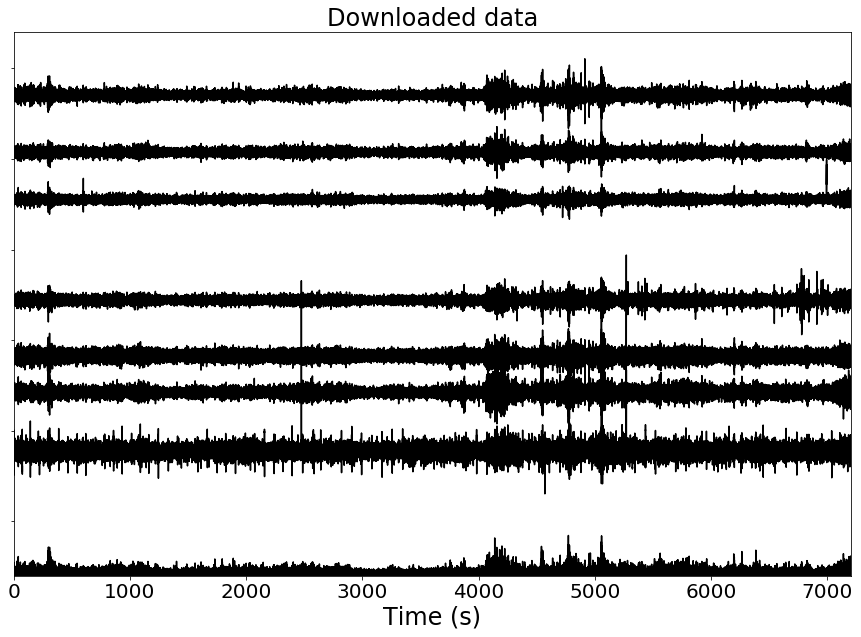

In [8]:
plot_2hour(D, 'E', 1200.0, 'Downloaded data')

We first need to detrend the data.

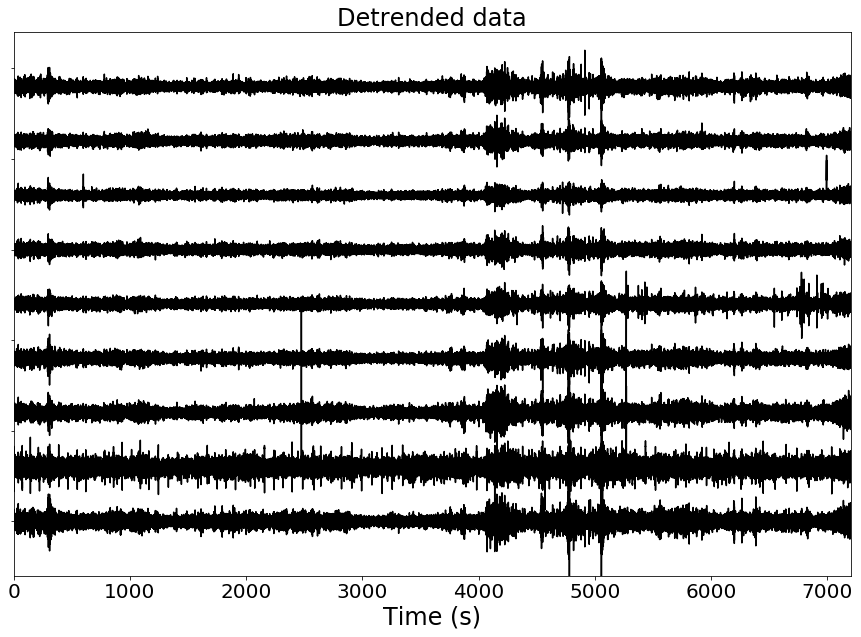

In [9]:
D.detrend(type='linear')
plot_2hour(D, 'E', 1200.0, 'Detrended data')

We taper the first and last five seconds of data with a Hann window.

/anaconda3/envs/seismic/lib/python3.6/site-packages/obspy/core/trace.py:2111: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(self.data.dtype, float):


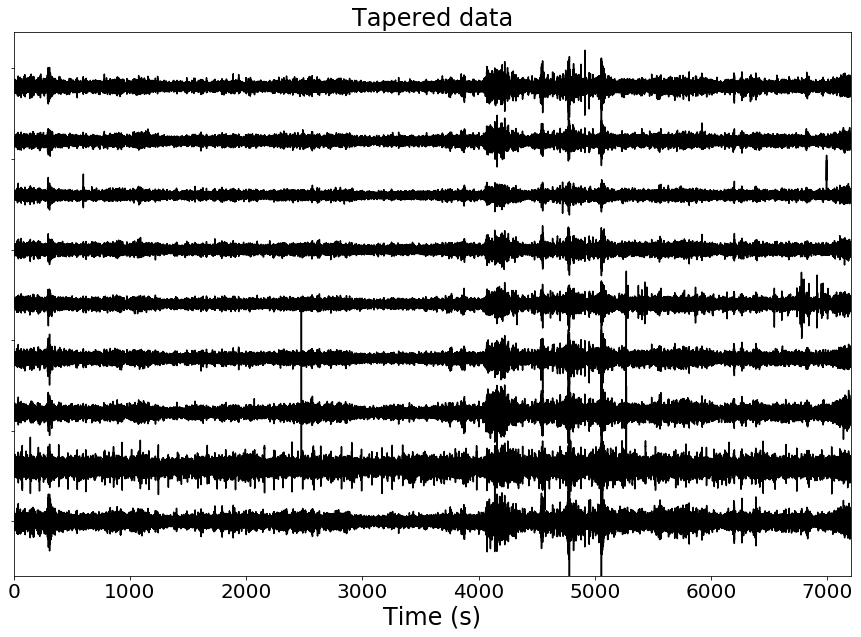

In [10]:
D.taper(type='hann', max_percentage=None, max_length=5.0)
plot_2hour(D, 'E', 1200.0, 'Tapered data')

We now want to remove the instrument response. We do this in the Fourier domain by dividing by the spectrum of the instrument filter. If we have downloaded the data from the IRIS DMC, all the information about the seismic stations have been downloaded with the data. If we have downloaded the data from the local server at ESS, the information about the seismic stations can be found in the xml files in the directory data/response. In this file, we can find the values of the gain, the poles and the zeros of the instrument filter. To avoid dividing by 0, we multiply the amplitude spectrum by 1 + $\epsilon$, where $\epsilon$ is the water level.

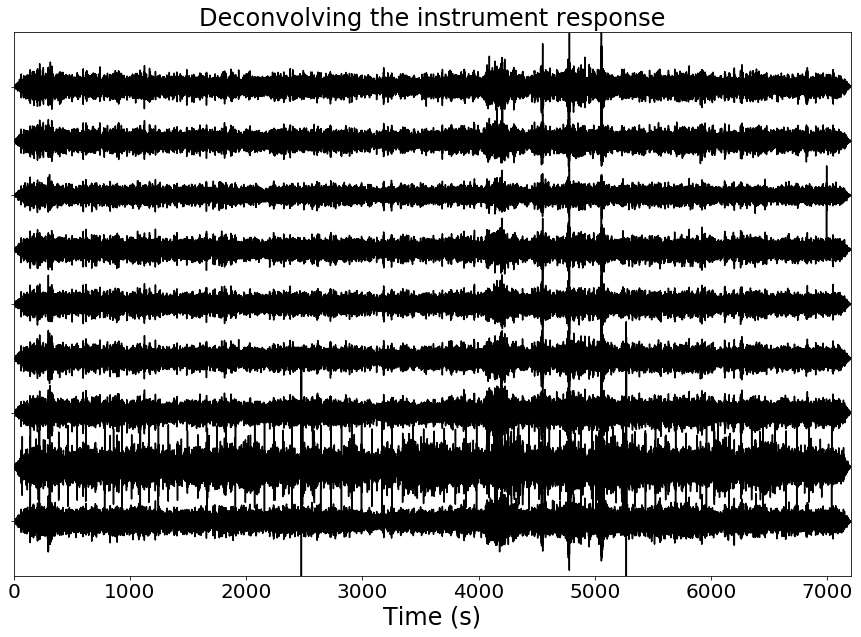

In [11]:
D.remove_response(output='VEL', pre_filt=(0.2, 0.5, 10.0, 15.0), water_level=80.0)

# or you can try:
# filename = '../data/response/' + network + '_' + arrayName + '.xml'
# inventory = read_inventory(filename, format='STATIONXML')
# D.attach_response(inventory)
# D.remove_response(output='VEL', pre_filt=(0.2, 0.5, 10.0, 15.0), water_level=80.0)

plot_2hour(D, 'E', 1.0e-6, 'Deconvolving the instrument response')

We then filter the data with a zero-phase bandpass filter between 2 and 8 Hz.

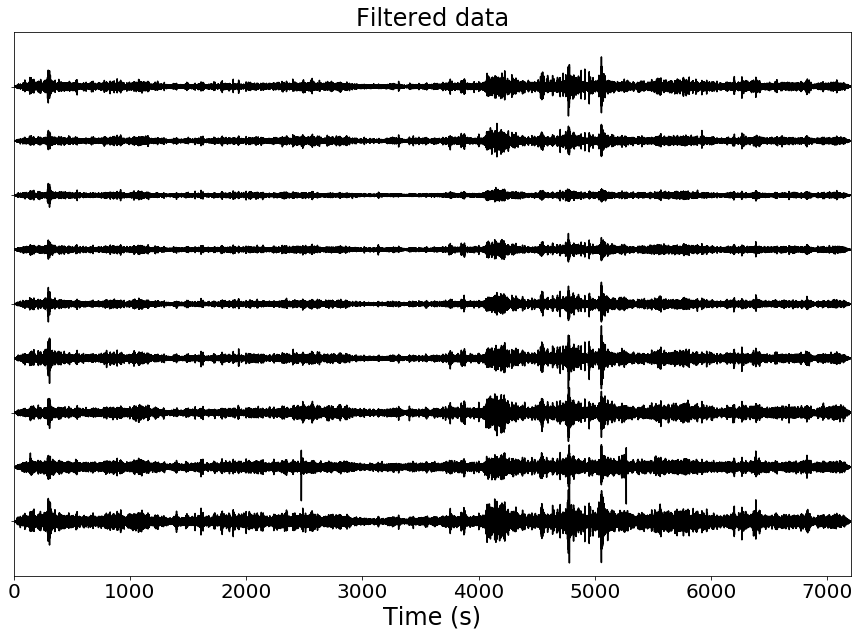

In [12]:
D.filter('bandpass', freqmin=2.0, freqmax=8.0, zerophase=True)
plot_2hour(D, 'E', 1.0e-6, 'Filtered data')

Finally, we resample the data from 0.02 s (50 Hz) to 0.05 s (20 Hz). This is mainly in order to reduce the computational cost of the following data analysis. As we have already filtered the data, we do not need to worry about aliasing.

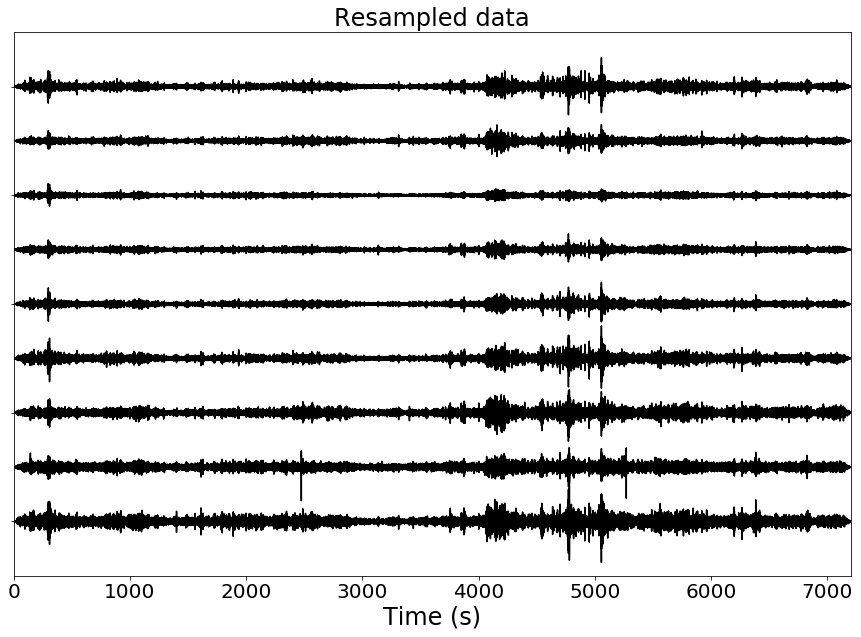

In [13]:
D.interpolate(100.0, method='lanczos', a=10)
D.decimate(5, no_filter=True)
plot_2hour(D, 'E', 1.0e-6, 'Resampled data')

We now select a 30-second-long time window and we cross correlate the vertical component with the east-west component for each of the seismic stations. By default, the data are normalized by the standard deviation before carrying out the cross correlation.

In [14]:
tdur = 30.0
ncor = 400
EW = D.select(component='E').slice(Tstart + 65 * tdur, Tstart + 66 * tdur)
UD = D.select(component='Z').slice(Tstart + 65 * tdur, Tstart + 66 * tdur)
cc = Stream()
for ksta in range(0, len(EW)):
    cc.append(EW[ksta].copy())
    cc[-1].data = correlate(EW[ksta], UD[ksta], ncor)
    cc[-1].stats['channel'] = 'CC'

We now stack the cross correlation over all the seismic stations.

We can choose a linear stack:
$$ S(t) = \frac{1}{n} \sum_{j = 1}^{n} X_j(t) $$

or an Nth-root stack:
$$ S(t) = sgn(V(t)) \lvert V(t) \rvert ^N $$

with:
$$ V(t) = \frac{1}{n} \sum_{j = 1}^{n} sgn(X_j(t)) \lvert X_j(t) \rvert ^{\frac{1}{N}} $$

or a phase-weighted stack:
$$ S(t) = \frac{1}{n} \sum_{j = 1}^{n} X_j(t) \lvert \frac{1}{n} \sum_{k = 1}^{n} exp(i\Phi_k(t)) \rvert ^N $$

where $\Phi_k(t)$ is the phase of the analytical signal:
$$ Y_k(t) = X_k(t) + i H(X_k(t)) = A_k(t) exp(i\Phi_k(t)) $$ 

In [15]:
stack = linstack([cc], normalize=False)

# or you can do:
# stack = powstack([cc], 2.0, normalize=False)
# stack = PWstack([cc], 2.0, normalize=False)

Let us now look at the cross correlation signal:

In [16]:
def plot_cc(cc, amp, ncor, Tmax, stack, title):
    """ Plot cross correlation
        cc = Stream
        amp = Amplification factor
        ncor = Maximum number of samples for cross correlation
        Tmax = Maximum time lag to be plotted
        stack = Stream
        title = Title of the figure       
    """
    fig, ax = plt.subplots(figsize=(15, 10))
    t = (1.0 / cc[0].stats.sampling_rate) * np.arange(- ncor, ncor + 1)
    for ksta in range(0, len(cc)):
        plt.plot(t, 2 * ksta + 1 + amp * cc[ksta].data, 'k')
    plt.plot(t, -1.0 + amp * 5.0 * stack[0].data, 'r')
    plt.xlim(0.0, Tmax)
    plt.ylim(-2.0, 2.0 * len(cc))
    plt.title(title, fontsize=24)
    plt.xlabel('Time lag (s)', fontsize=24)
    ax.set_yticklabels([])
    ax.tick_params(labelsize=20)

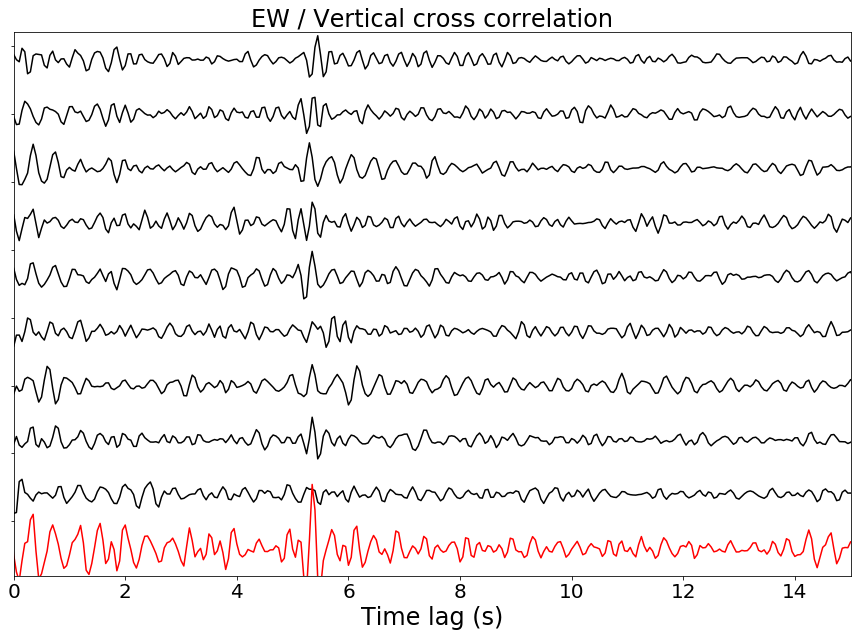

In [17]:
plot_cc(cc, 3.0, 400, 15.0, stack, 'EW / Vertical cross correlation')

We can see that there is a peak in the cross correlation signal at about 5.5 s. It is clearly seen in the stacked data (red line).

Now let us compute, stack over the stations, and plot the cross correlation for the one hundred and twenty 30-second-long time windows in the first hour of tremor that we have downloaded.

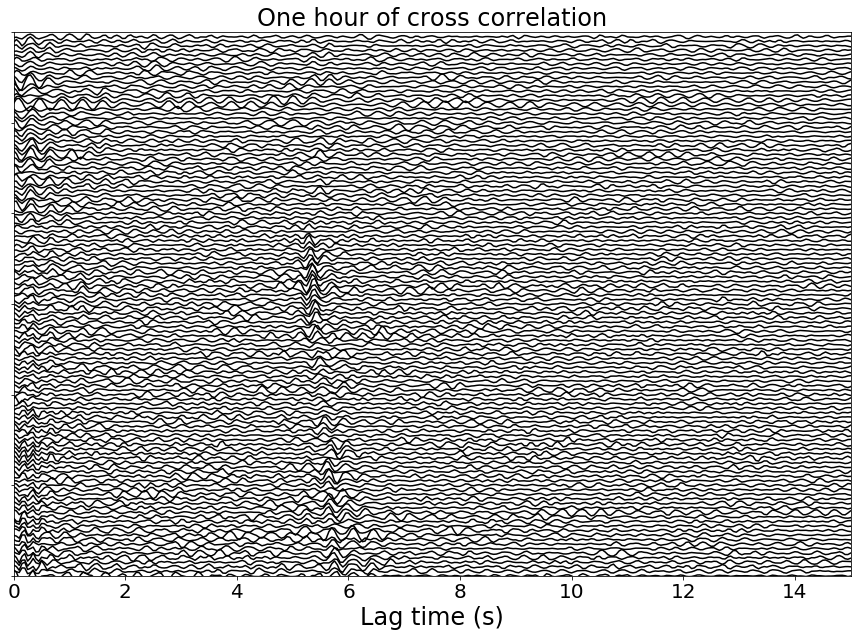

In [18]:
fig, ax = plt.subplots(figsize=(15, 10))
for kt in range(0, 120):
    EW = D.select(component='E').slice(Tstart + kt * tdur, Tstart + (kt + 1) * tdur)
    UD = D.select(component='Z').slice(Tstart + kt * tdur, Tstart + (kt + 1) * tdur)
    cc = Stream()
    for ksta in range(0, len(EW)):
        cc.append(EW[ksta].copy())
        cc[-1].data = correlate(EW[ksta], UD[ksta], ncor)
        cc[-1].stats['channel'] = 'CC'
    t = (1.0 / cc[0].stats.sampling_rate) * np.arange(- ncor, ncor + 1)
    plt.plot(t, kt * 0.1 + linstack([cc], normalize=False)[0].data, 'k-')

# or you can do:
#     plt.plot(t, kt * 0.5 + powstack([cc], 2.0, normalize=False)[0].data, 'k-')
#     plt.plot(t, kt * 0.05 + PWstack([cc], 2.0, normalize=False)[0].data, 'k-')

plt.xlim(0.0, 15.0)
plt.ylim(0.0, 120 * 0.1)
plt.title('One hour of cross correlation', fontsize=24)
plt.xlabel('Lag time (s)', fontsize=24)
ax.set_yticklabels([])
ax.tick_params(labelsize=20)

We can see a peak in the cross correlation between 5 s and 6 s. It is visible for the first 40 minutes of the one-hour-long time window that we have analyzed. At that time, the source of the tremor was located around 20 km west of the array. With a P-wave velocity of 6.4 km/s, an S-wave velocity of 3.6 km/s, and a depth of the plate boundary of 36.8 km, it corresponds to a time lag between the direct P-wave and the direct S-wave of 5.1 s. This is consistent with what we observe in the cross correlation figure.

For a more systematic way of analyzing the data, you can use the module timelags/stack_ccorr_2hour.py

## References

A. Ghosh, J.E. Vidale, and K.C. Creager. Tremor asperities in the transition zone control evolution of slow
earthquakes. Journal of Geophysical Research, 117:B10301, 2012.